In [2]:
import numpy as np
layers = []
layer = {}
layer['inp_modes'] = np.array([4, 7, 4, 7], dtype='int32')
layer['out_modes'] = np.array([5, 5, 8, 4], dtype='int32')
layers.append(layer)

layer['inp_modes'] = layer['out_modes']
layer['out_modes'] = np.array([4, 4, 4, 4], dtype='int32')
layers.append(layer)

def compres_ratio_tt(layers,ranks):
    full_sz = 0.0
    compres_sz = 0.0
    for layer,rank in zip(layers, ranks):
        inp_modes = layer['inp_modes']
        out_modes = layer['out_modes']
        full_sz += np.prod(inp_modes*out_modes)
        compres_sz += np.sum((rank[:-1]*inp_modes*out_modes*rank[1:]))
    return compres_sz / full_sz

def compres_ratio_tucker(layers,ranks):
    full_sz = 0.0
    compres_sz = 0.0
    for layer,rank in zip(layers, ranks):
        inp_modes = layer['inp_modes']
        out_modes = layer['out_modes']
        full_sz += np.prod(inp_modes*out_modes)
        compres_sz += np.sum(inp_modes*out_modes*rank)+np.prod(rank)
    return compres_sz / full_sz

def compres_ratio_cp(layers,ranks):
    full_sz = 0.0
    compres_sz = 0.0
    for layer,rank in zip(layers, ranks):
        inp_modes = layer['inp_modes']
        out_modes = layer['out_modes']
        full_sz += np.prod(inp_modes*out_modes)
        compres_sz += np.sum(inp_modes*out_modes)*rank+ 1
    return compres_sz / full_sz

def compres_ratio_mf(layers, ranks):
    full_sz = 0.0
    compres_sz = 0.0
    for layer,rank in zip(layers, ranks):
        inp_modes = layer['inp_modes']
        out_modes = layer['out_modes']
        full_sz += np.prod(inp_modes*out_modes)
        compres_sz += np.sum(np.prod(inp_modes)+np.prod(out_modes)) * rank
    return compres_sz / full_sz
    
    
    
    
# load test error results
path_name = '/home/roseyu/Python/TensorCompress/experiments/'
with open(path_name + 'mnist/2-layer-tt/results/res_tt', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
tt_err = np.array([float(x) for x in tokens])


with open(path_name + 'mnist/2-layer-tucker/results/res_tucker', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
tucker_err = np.array([float(x) for x in tokens])

with open(path_name + 'mnist/2-layer-cp/results/res_cp', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
cp_err = np.array([float(x) for x in tokens])
cp_err = np.delete(cp_err,5)


with open(path_name + 'mnist/2-layer-mf/results/res_mf', 'r') as f:
    line = f.read()
    tokens = line.strip().split()
mf_err = np.array([float(x) for x in tokens])

tt_compres = np.zeros((5,))
tucker_compres = np.zeros((5,))
cp_compres = np.zeros((5,))
mf_compres = np.zeros((5,))
i = 0
for rank_val in range(1,6):
    tt_layer_ranks = [np.hstack(([1],np.ones(3, dtype='int32')*rank_val,[1])),
                              np.hstack(([1],np.ones(3, dtype='int32')*rank_val,[1]))]
    tt_compres[i] = compres_ratio_tt(layers, tt_layer_ranks)

    tucker_layer_ranks = [np.ones(4, dtype='int32')*rank_val, np.ones(4, dtype='int32')*rank_val]
    tucker_compres[i] = compres_ratio_tucker(layers, tucker_layer_ranks)
    
    # change the last point of compression due to slow decay
    if rank_val ==5:
        rank_val_cp = 15
    else:
        rank_val_cp = rank_val
    
    cp_layer_ranks = [rank_val_cp, rank_val_cp]
    cp_compres[i] = compres_ratio_cp(layers, cp_layer_ranks)
    
    mf_layer_ranks = [rank_val, rank_val]
    mf_compres[i] = compres_ratio_mf(layers, mf_layer_ranks)
    
    i = i+1
print tt_compres
print tucker_compres
print cp_compres
print mf_compres

[ 0.00042969  0.00136719  0.0028125   0.00476562  0.00722656]
[ 0.00043457  0.0009375   0.00168457  0.00296875  0.0052002 ]
[ 0.00043457  0.00086426  0.00129395  0.00172363  0.0064502 ]
[ 0.00515625  0.0103125   0.01546875  0.020625    0.02578125]


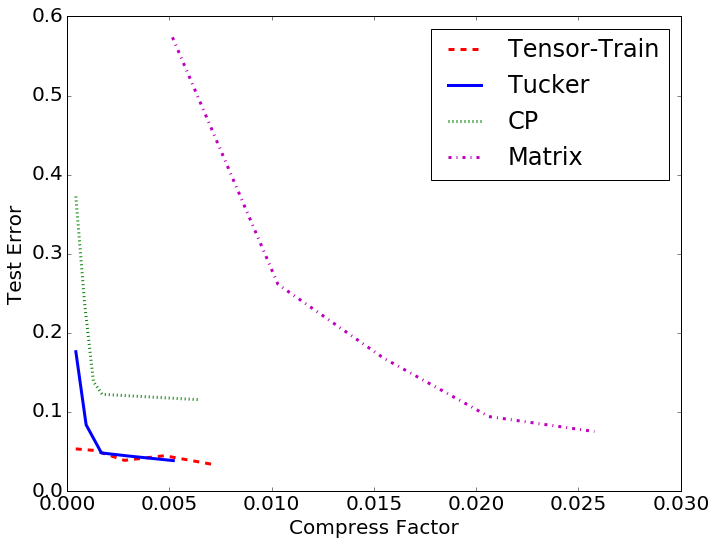

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(11, 8.5), dpi=600)
matplotlib.rcParams.update({'font.size': 20})
plt.plot(tt_compres, tt_err, 'r--', tucker_compres, tucker_err, 'b-', 
         cp_compres, cp_err, 'g:', mf_compres, mf_err, 'm-.',  linewidth = 3)
plt.legend(['Tensor-Train', 'Tucker', 'CP','Matrix'])
plt.xlabel('Compress Factor')
plt.ylabel('Test Error')
plt.savefig('err_ratio_cmp.pdf', format='pdf')